# **Pronóstico y Predicción - Model Fitness : Descripción del proyecto**
La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con el cliente basada en datos analíticos. Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. 
 
**Objetivo:** Analizar los datos y elaborar una estrategia de retención de clientes:
1. Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente
2. Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales
3. Analizar los factores que más impactan la pérdida
4. Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
5. Identificar a los grupos objetivo
6. Sugerir medidas para reducir la rotación
7. Describir cualquier otro patrón que observes con respecto a la interacción con los clientes

## **Dataset**
Model Fitness aportó archivos CSV que contenían los datos sobre cancelación de un mes en concreto e información del mes que lo precedía. El dataset incluye los siguientes campos:

* `Churn` — la cancelación para el mes en cuestión
* `gender`
* `Near_Location` — si el usuario vive o trabaja en el vecindario donde se encuentra el gimnasio
* `Partner` — si el usuario es un trabajador de una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes)
* `Promo_friends` — si el usuario originalmente se inscribió mediante una oferta "trae a un amigo" (se utilizó el código promocional de un amigo cuando pagaron el primer abono)
* `Phone` — si el usuario aportó el número de teléfono
* `Age`
* `Lifetime` — el tiempo (en meses) desde que el usuario llegó por primera vez al gimnasio
Datos del registro de visitas y compras y datos sobre el estado actual de la membresía
* `Contract_period` — 1 mes, 3 meses, 6 meses o 1 año
* `Month_to_end_contract` — los meses que faltan hasta que expire el contrato
* `Group_visits` — si el usuario participa en sesiones grupales
* `Avg_class_frequency_total` — frecuencia media de visitas por semana a lo largo de la vida del cliente
* `Avg_class_frequency_current_month` — frecuencia media de visitas por semana en el mes anterior
* `Avg_additional_charges_total` — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

### **Librerías e información general**

In [86]:
import pandas as pd
import seaborn as sns
import math
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, silhouette_score

In [2]:
gym_clients = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn_us.csv')

In [3]:
gym_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

No parece haber valores ausentes o duplicados en el dataset, continuaremos con el preprocesamiento y EDA.

## **Preprocesamiento**

In [4]:
gym_clients = gym_clients.rename(columns=str.lower)
gym_clients['avg_additional_charges_total'] = gym_clients['avg_additional_charges_total'].round(decimals = 2)
gym_clients['avg_class_frequency_total'] = gym_clients['avg_class_frequency_total'].round(decimals = 2)
gym_clients['avg_class_frequency_current_month'] = gym_clients['avg_class_frequency_current_month'].round(decimals = 2) # Redondeando
gym_clients['month_to_end_contract'] = gym_clients['month_to_end_contract'].astype('int64') # Convirtiendo a entero
gym_clients['contract'] = (gym_clients['contract_period'].map({1:'1m', 3:'3m', 6:'6m', 12:'1y'})) # Separando por meses contratados
gym_clients = gym_clients.drop(['contract_period'], axis =1)

In [5]:
gym_clients = gym_clients.rename(columns=
                 {'avg_class_frequency_total':'freq_week',
                  'avg_class_frequency_current_month':'freq_month',
                  'month_to_end_contract':'month_to_end',
                  'avg_additional_charges_total':'service_charge'}) # Renombrando columnas muy largas

In [6]:
gym_clients = pd.get_dummies(gym_clients) # Separando de acuerdo a la variable categorica de los meses contratados
gym_clients.head(5)

,gender,near_location,partner,promo_friends,phone,group_visits,age,service_charge,month_to_end,lifetime,freq_week,freq_month,churn,contract_1m,contract_1y,contract_6m
0,1,1,1,1,0,1,29,14.23,5,3,0.02,0.00,0,0,0,1
1,0,1,0,0,1,1,31,113.20,12,7,1.92,1.91,0,0,1,0
2,0,1,1,0,1,0,28,129.45,1,2,1.86,1.74,0,1,0,0
3,0,1,1,1,1,1,33,62.67,12,2,3.21,3.36,0,0,1,0
4,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0,1,0,0


En esta sección hemos cambiado las cabeceras de las columnas todas a lowercase y cambiamos algunos nombres por conveniencia, redondeamos los valores no enteros a 2 decimales y cambiamos el tipo de datos de la columna `month_to_end_contract` a entero. Creamos unas nuevas columnas para que mostrara el tipo de contrato (meses) que tenia en tiempo y descartamos la columna original ya que es una variable categorica.

## **EDA**

### **Valores promedio y desviación estándar**

In [67]:
gym_clients.describe().loc[['std','mean']].round(2)

,gender,near_location,partner,promo_friends,phone,group_visits,age,service_charge,month_to_end,lifetime,freq_week,freq_month,churn,contract_1m,contract_1y,contract_6m
std,0.50,0.36,0.50,0.46,0.3,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44,0.50,0.43,0.41
mean,0.51,0.85,0.49,0.31,0.9,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27,0.55,0.24,0.21


### **Valores medios de las características (churn & churn't)**

In [8]:
gym_churn = (gym_clients.groupby('churn').mean().round(2).transpose().rename(columns={0:'False',1:'True'}))
gym_churn

churn,False,True
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
group_visits,0.46,0.27
age,29.98,26.99
service_charge,158.45,115.08
month_to_end,5.28,1.66
lifetime,4.71,0.99


Con esta tabla podemos analizar todas las características y podemos concluir que:
* La distribución de hombres y mujeres es muy equitativa
* Los clientes locales son los que menos tienden a abandonar el gym
* Los clientes que han participado en la promoción de invitar a un amigo tienden a permanecer
* Los clientes que han abandonado no tienden a asistir a clases grupales
* Las edades promedio entre los grupos difiere un poco, los clientes con una edad un poco más grande (29-30 años) tienden a mantenerse constantes a diferencia de los más jovenes (26-27 años)
* Los clientes que tienden a permancer constantes han sido los que tienen un promedio de cargos por servicios extra más elevado (158.45) a diferencia de los que se han ido (115.08)
* En cuanto a los meses que contratan, los clientes que tienden a abandonar el ginmasio son los que contratan periodos más cortos y que menos aisistencias tienen mientras que los clientes que permanecen asisten más frecuentemente al ginmasio y contratan periodos más largos de tiempo


### **Histogramas de barras y distribuciones de características**

Tenemos características tanto numéricas como categóricas. Crearemos gráficos que mostrarán la distribución de las características de acuerdo con la característica de si son clientes del gimnasio que ya no asisten (churn) o si siguen asistiendo (churn't). 

In [9]:
gym_churn = gym_clients.query('churn == 1') # Los que se fueron
gym_churnt = gym_clients.query('churn == 0') # Los que se quedaron

In [62]:
def histogram(column, title, x_title): # Función para graficar las distribuciones por característica.
  fig = go.Figure()
  fig = px.histogram(gym_clients, x=column, nbins=25, color="churn", title=title, width=500, height=400, opacity=0.75, barmode='group')
  fig.update_xaxes(title_text=x_title)
  fig.update_yaxes(title_text='Número de clientes')
  fig.show()

In [63]:
histogram('gender', "Distribución por género", "Hombre/Mujer") # Características categóricas
histogram('near_location', "Distribución por clientes locales y no locales", "Locales/No locales")
histogram('partner', "Distribución por ser partner de empresa", "No partner/Sí parnter")
histogram('promo_friends', "Distribución por llevar un amigo", "No trajo/Sí trajo")
histogram('group_visits', "Distribución por visitas grupales", "No clases grupales/Sí clases grupales")

En este primer set de gráficas tenemos todas las variables categóricas y podemos ver como se distribuyen de acuerdo a si siguen asisitiendo al gym o si ya nos han abandonado.

In [64]:
histogram('age', "Distribución por Edad", "Edad") # Características numéricas
histogram('service_charge', "Distribución por servicios extras", "Precios")
histogram('month_to_end', "Distribución por meses que faltan", "Meses")
histogram('lifetime', "Distribución del tiempo de vida del cliente", "Meses")
histogram('freq_week', "Distribución promedio de visitas semanales", "Visitas Semanales")
histogram('freq_month', "Distribución promedio de visitas mensuales", "Visitas mensuales")

In [66]:
histogram('contract_1m', "Distribución por contrato de 1 mes", "Otros/1 mes de contrato") # Características del contrato
histogram('contract_6m', "Distribución por contrato de 6 meses", "Otros/6 meses de contrato")
histogram('contract_1y', "Distribución por contrato de 1 año", "Otros/1 año de contrato")

Con estas gráficas podemos observar los comportamientos de los clientes a grandes rasgos, tomando si son clientes que ya no asisten al gimnasio o si siguen yendo.

### **Correlación**

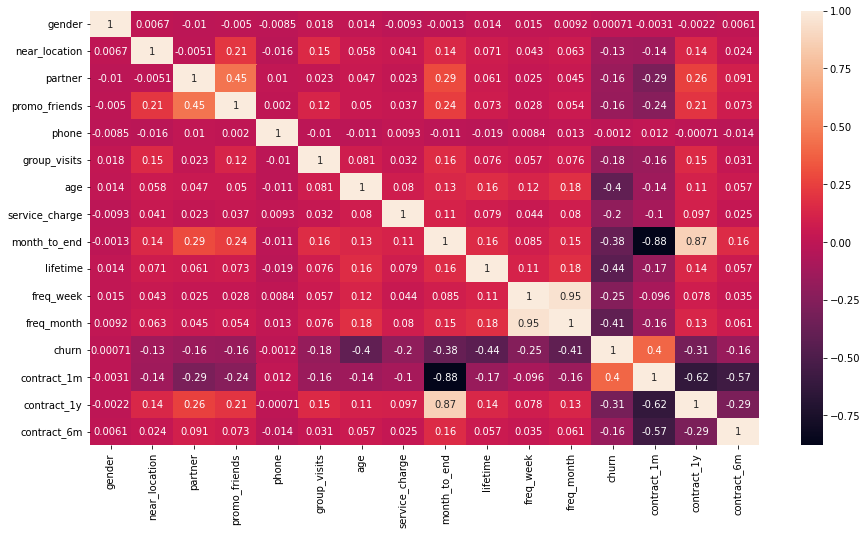

In [79]:
fig, ax = plt.subplots(figsize=(15,8))
gym_heatmap = gym_clients.corr() 
sns.heatmap(gym_heatmap, ax=ax, annot=True)

Con este mapa de calor podemos observar que las características que tienen una mayor correlacion son:
* `contract_1y` vs `month_to_end`
* `contract_1m` vs `month_to_end`
* `freq_week` vs `freq_month`

Las características que máyor correlación tuvieron con la variable `churn` fueron: `age` con -0.4, `lifetime`con -0.44, `freq_month`con -0.41 y `contract_1m` con 0.4.

## **Modelo de Predicción**

### **Entrenamiento y validación**

En esta sección utilizaremos dos modelos de predicción para predecir la probabilidad de los clientes de abandonar el próximo mes. Utilizaremos regresión logística y bosque a leatorio.

In [81]:
X = gym_clients.drop('churn', axis = 1)
y = gym_clients['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

#### ***Regresión Logística***

In [82]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

#### ***Bosque Aleatorio***

In [83]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### **Evaluación de modelos**

In [84]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Métricas de clasificación'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [88]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Métricas para regresión logística:')

Métricas para regresión logística:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [87]:
print_all_metrics(y_test, rf_predictions, rf_probabilities, title= 'Métricas para random forest:')

Métricas para random forest:
	Accuracy: 0.90
	Precision: 0.82
	Recall: 0.78
	F1: 0.80
	ROC_AUC: 0.96


Después de entrenar ambos modelos y calcular las métricas para cada uno, podemos ver que las métricas de la regresión logística son superiores a las del bosque aleatorio.

## **Clústeres**

In [90]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

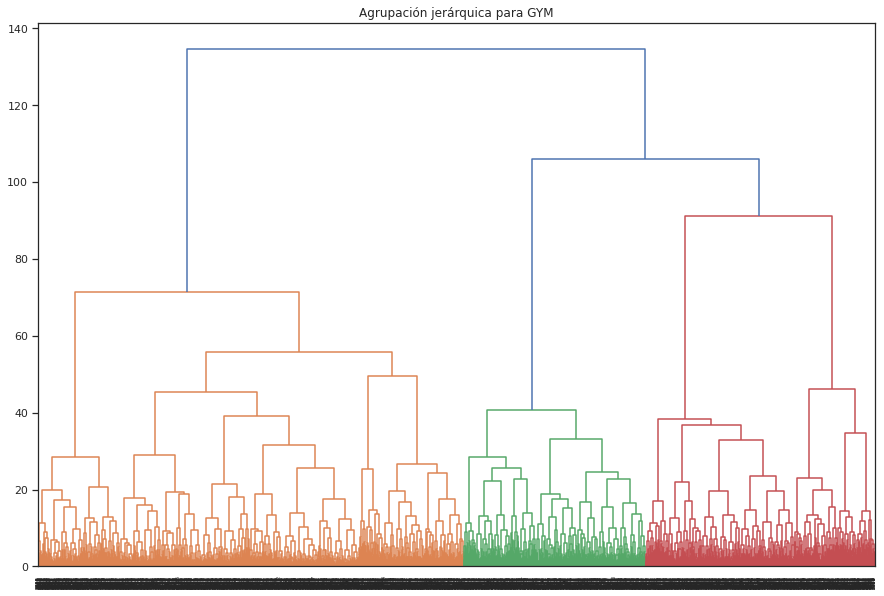

In [115]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica para GYM')
plt.show() 

In [126]:
km = KMeans(n_clusters = 5) # establecer el número de clústeres en 5
labels = km.fit_predict(x_sc)
gym_clients['cluster_km'] = labels
gym_clients.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.559671,0.508333,0.470869,0.516827,0.513889
near_location,0.990398,0.932292,1.000000,0.861779,0.000000
partner,0.331962,0.715625,0.338109,0.575721,0.428241
promo_friends,0.270233,0.477083,0.225406,0.375000,0.071759
phone,0.903978,0.903125,0.908309,0.895433,0.907407
group_visits,0.466392,0.544792,0.319962,0.442308,0.192130
age,30.167353,29.816667,27.973257,29.544471,28.361111
service_charge,159.567202,163.590021,126.075769,151.380228,130.681319
month_to_end,1.004115,10.839583,1.000000,5.617788,1.000000
lifetime,5.008230,4.664583,2.120344,4.137019,2.564815


### **Distribuciones de características para los clústeres**

In [123]:
numeric_data_list = ['age',
                     'service_charge',
                     'month_to_end', 
                     'lifetime',
                     'freq_month',
                     ]

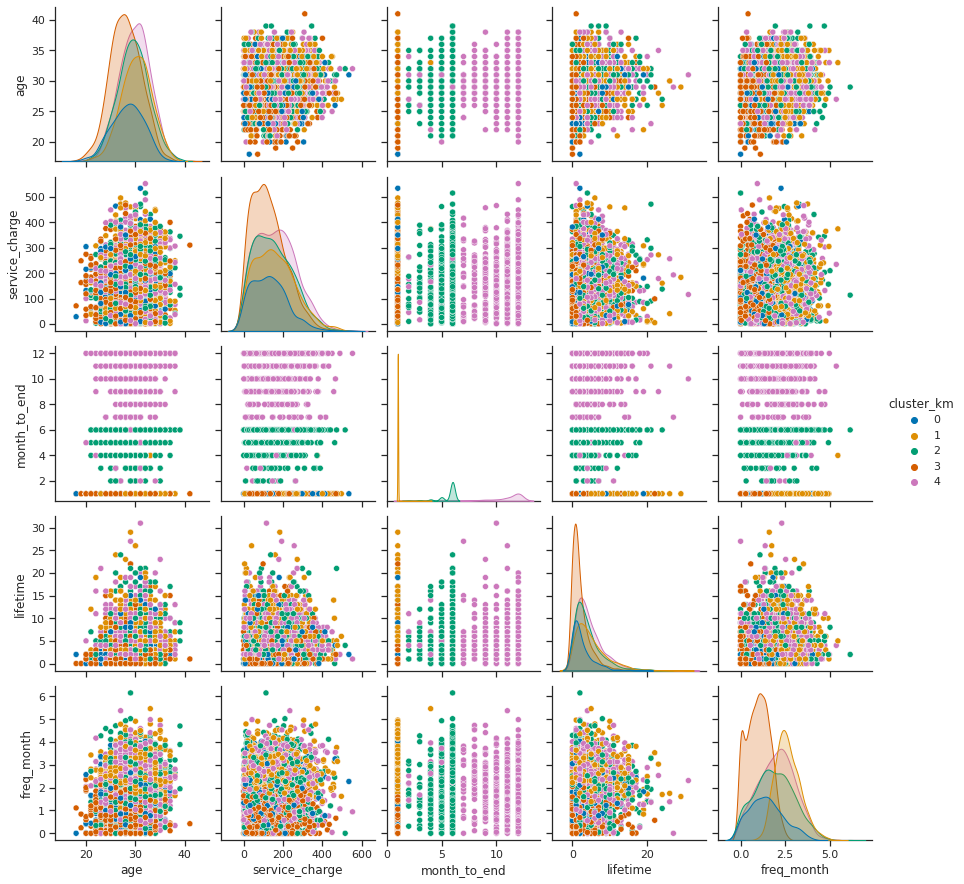

In [118]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(X, hue='cluster_km', palette = "colorblind",
                 vars =numeric_data_list)
plt.show()

In [124]:
print('El valor de silueta es de {:.2f}'.format(silhouette_score(x_sc, labels)))

El valor de silueta es de 0.16


Podemos aprecair en la tabla de distribuciones que los clústeres 4 y 2 presentan diferencias comparados con los clústeres 0, 1 y 2, los cuales se ven más encimados.

### **Tasa de cancelación para clústeres**

In [131]:
cluster = (gym_clients.query('churn == 1').
    groupby('cluster_km').
    agg({'cluster_km':'count'}).
    rename(columns={'cluster_km':'churn'}).
    reset_index()
)
cluster['total'] = gym_clients.groupby('cluster_km').agg({'cluster_km':'count'})
cluster['churn_ratio'] = cluster['churn'] / cluster['total']
cluster

,cluster_km,churn,total,churn_ratio
0,0,70,729,0.096022
1,1,23,960,0.023958
2,2,639,1047,0.610315
3,3,104,832,0.125000
4,4,225,432,0.520833


In [143]:
def histogram(column, title, x_title): # Función para graficar las distribuciones por característica.
  fig = go.Figure()
  fig = px.histogram(cluster, x=column, nbins=25, color="cluster_km", title=title, width=500, height=400, opacity=0.75, barmode='group')
  fig.update_xaxes(title_text=x_title)
  fig.update_yaxes(title_text='Número de clientes')
  fig.show()

In [147]:
histogram('churn_ratio', 'Churn rate', 'Cluster 0')
histogram('churn', 'Churn rate', 'Cluster 0')

Con estos datos y gráficas que hemos obtenido, podemos observar que los clústeres 4 y 2 son los que más probabilidad de desertar tienen con 52% y 61% respectivamente. Mientras que los clústeres 0, 1 y 3 tienen probabilidades más bajas de abandonar su asistencia con 9.6% 2.3% y 12.5% cada uno.

## **Conclusiones y Recomendaciones**

En general podemos concluir que los clientes de los clústers 4 y 2 son más propensos a abandonar su asistencia, mientras que los clústeres 0, 1 y 3 tienen mayor probabilidad de continuar y ser clientes frecuentes que utilizan todos los servicios del gimnasio. Los que desertan por lo general no son clientes locales (se tienen que desplazar y tal vez eso afecta su decision de asistir con mayor frecuencia), suelen contratar 1 mes solamente (puede ser porque están probando y no gustan de adquirir un compromiso a largo plazo) y por lo general no asisten a clases grupales o utilizan el pase de amigos.

Una de las recomendaciones que podría incentivar a los clientes del gimnasio es una app o una dinámica en la que se premie por su asistencia con descuentos y promociones mientras más visitas vayan acumulando, estas promociones podrían darse en la contratación de planes de mayores periodos de tiempo que 1 mes y ciertos descuentos en los servicios adicionales con los que cuenta el gimnasio. También se podría incentivar el llevar a un amigo y organizar pequeños eventos grupales en los que se obsequie merch o se haga algún concurso de asistencia y premiarlos con merch del gimnasio.